In [1]:
#plot subject prediction plots and zoomed in views on figure 3

Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/kw350


In [ ]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH
from meld_classifier.experiment import Experiment
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.dataset import load_combined_hemisphere_data, Dataset
from meld_classifier.training import Trainer
from meld_classifier.evaluation import Evaluator
import os
import json
import glob
import h5py
import numpy as np
# import logging
# # set logging to debug to see all messages (set to INFO in real scripts)
# logging.basicConfig(level=logging.FATAL)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import gridspec
import matplotlib_surface_plotting as msp
import subprocess 
from PIL import Image


def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results#

In [2]:
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
        dataset='MELD_dataset_V6.csv')


In [3]:
#subjects=c.get_subject_ids(group='patient')

In [4]:
folder1  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results/'
res_file = os.path.join(folder1,'test_results.csv')
test_df=pd.read_csv(res_file,index_col=False)
test_df.drop_duplicates(inplace=True,ignore_index=True)
test_df.groupby('group').mean()
fp = test_df['n_clusters']<1
test_df['any']=fp
test_df.border=test_df.border>100
#test_df.detected+=test_df.border
test_df=test_df.dropna()
test_df.detected=test_df.detected.astype(int)

folder2  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-17/ensemble_21-09-20/fold_all/results/'
res_file = os.path.join(folder2,'test_results.csv')
n = pd.read_csv(res_file,index_col=False)
n.drop_duplicates(inplace=True,ignore_index=True)
n.dropna(inplace=True)

fp = n['n_clusters']<1
n['any']=fp
n.border=n.border>100
#n.detected+=n.border
n=n.dropna()

test_df=test_df.append(n,ignore_index=True)
test_df['group']=test_df['group'].astype(bool)
demographics_file = '/home/kw350/rds/rds-kw350-meld/meld_data/Data/demographics_qc_allgroups.csv'

demographics = pd.read_csv(demographics_file,index_col=False)

In [5]:
def get_sites(sub_df,  demographics):
    sites=[]
    for sub in sub_df.ID:
        sites.append(demographics.Site[demographics.ID==sub].values[0])
    sub_df['Site'] = sites
    return sub_df

In [6]:
best_subjects = test_df[np.logical_and(test_df.n_clusters==1,test_df.detected==1)]
best_subjects = get_sites(best_subjects,demographics)
border_subjects = test_df[np.logical_and(test_df.n_clusters==1,test_df.border==1)]
border_subjects = get_sites(border_subjects,demographics)
good_subjects = test_df[np.logical_and(np.logical_and(test_df.n_clusters>1,test_df.n_clusters<5),test_df.detected==1)]
good_subjects = get_sites(good_subjects,demographics)
bad_subjects = test_df[np.logical_and(test_df.n_clusters>0,np.logical_and(test_df.group,test_df.detected==0))]
bad_subjects = get_sites(bad_subjects,demographics)
all_dfs = [best_subjects,good_subjects,border_subjects,bad_subjects]

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [24]:
best_subjects[best_subjects['Site']=='H16']

,ID,group,detected,n_clusters,border,any,Site
330,MELD_H16_3T_FCD_004,True,1,1,False,False,H16
331,MELD_H16_3T_FCD_005,True,1,1,False,False,H16
332,MELD_H16_3T_FCD_008,True,1,1,False,False,H16
333,MELD_H16_3T_FCD_010,True,1,1,False,False,H16
335,MELD_H16_3T_FCD_015,True,1,1,False,False,H16
339,MELD_H16_3T_FCD_023,True,1,1,False,False,H16
760,MELD_H16_3T_FCD_012,True,1,1,False,False,H16
761,MELD_H16_3T_FCD_014,True,1,1,False,False,H16
764,MELD_H16_3T_FCD_021,True,1,1,False,False,H16
765,MELD_H16_3T_FCD_024,True,1,1,False,False,H16


In [7]:
test_df = get_sites(test_df,demographics)
all_sites = np.unique(test_df.Site.values)
sites_dict = {}
for b,s in enumerate(all_sites):
    sites_dict[s]=b

In [10]:
import meld_classifier.mesh_tools as mt
import meld_classifier.paths as paths

surf = mt.load_mesh_geometry(os.path.join(paths.BASE_PATH,'fsaverage_sym',
                                          'surf','lh.partial_inflated'))

In [11]:
def create_surface_plots(surf,c,prediction,boundary):
    """plot and reload surface images"""
    parcel_cmap = {#0:np.array([1,0,0,1]),
                  1:np.array([0,0,0,1]),
                  2:np.array([1,0,0,1]),
                  }
    msp.plot_surf(surf['coords'],
                                           surf['faces'],prediction,
              rotate=[90],
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=0,vmax=1,cmap='turbo',
              base_size=20,parcel=boundary,parcel_cmap=parcel_cmap,
              filename='tmp.png'
             );
    subprocess.call(f"convert ./tmp.png -trim ./tmp1.png", shell=True)
    im = Image.open('tmp1.png')
    im = im.convert("RGBA")
    im1 = np.array(im)
    msp.plot_surf(surf['coords'],
                                           surf['faces'],prediction,
              rotate=[270],
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=0,vmax=1,cmap='turbo',
              base_size=20,parcel=boundary,parcel_cmap=parcel_cmap,
              filename='tmp.png'
             );
    subprocess.call(f"convert ./tmp.png -trim ./tmp1.png", shell=True)
    im = Image.open('tmp1.png')
    im = im.convert("RGBA")
    im2 = np.array(im)
    plt.close('all')
    return im1,im2

In [12]:
def get_image(subject,x=None,z=None,cohort=c):
    subj = MeldSubject(subject,cohort=c)
    try:
        hdf_predictions = os.path.join(folder1,'predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    except KeyError:
        hdf_predictions = os.path.join(folder2,'predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    boundary_zones=subj.load_boundary_zone(max_distance=None)
    if boundary_zones[0]>0:
        hemi='lh'
        boundary = boundary_zones[:len(boundary_zones)//2]
    else:
        hemi='rh'
        boundary = boundary_zones[len(boundary_zones)//2:]
    #0 outside, 1 border, 2 lesion
    boundary_full = np.zeros_like(c.cortex_mask,dtype=int)
    boundary_full[~c.cortex_mask]=2
    boundary_full[c.cortex_mask] += 2*(boundary>20).astype(int)
    boundary_full[c.cortex_mask] += boundary<0.1
    prediction_c = result_hemis[hemi]
    prediction = np.zeros_like(c.cortex_mask,dtype=int)
    prediction[c.cortex_mask] = prediction_c
    surf,c,prediction,boundary_full
    #msp.plot_surf
    a,b=create_surface_plots(surf,c,prediction,boundary_full)
    if hemi=='rh':
        a=a[:,::-1]
        b=b[:,::-1]
    if x is not None:
        parcel_cmap = {#0:np.array([1,0,0,1]),
                  1:np.array([0,0,0,1]),
                  2:np.array([1,0,0,1]),
                  }
        msp.plot_surf(surf['coords'],
               surf['faces'],prediction,
              rotate=[x],z_rotate=z,
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=0,vmax=1,cmap='turbo',
              base_size=20,parcel=boundary_full,parcel_cmap=parcel_cmap,
              filename='tmp.png')
        subprocess.call(f"convert ./tmp.png -trim ./tmp1.png", shell=True)
        im = Image.open('tmp1.png')
        im = im.convert("RGBA")
        rot = np.array(im)
        if hemi=='rh':
            rot=rot[:,::-1]
        return a,b,rot
    return a,b

In [11]:
import importlib
importlib.reload(msp)

<module 'matplotlib_surface_plotting' from '/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/matplotlib_surface_plotting/__init__.py'>

In [25]:
a,b=get_image('MELD_H16_3T_FCD_004',cohort=c,)

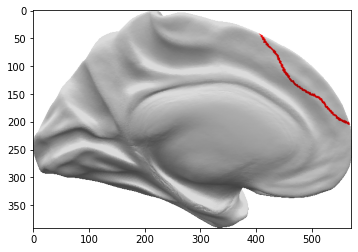

In [26]:
plt.imshow(b)

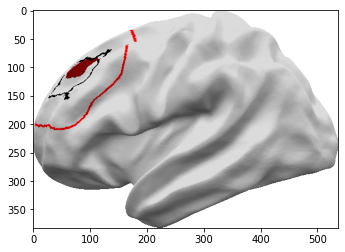

In [27]:
plt.imshow(a)

In [58]:
#rotate and z rotate

excellent = {'MELD_H14_3T_FCD_0001':[160,0,-20,40],
             'MELD_H2_3T_FCD_0011':[120,40,-60,-60],
             'MELD_H3_3T_FCD_0001':[270,320,0,100]
            }

good = { 'MELD_H11_3T_FCD_0040':[120,0,-30,-90]}
borderzone = { 'MELD_H5_3T_FCD_0010':[130,40,-60,20]}
missed = {'MELD_H2_15T_FCD_0008':[90,70,-20,-20]}
list_of_mats = [excellent,good,borderzone,missed]

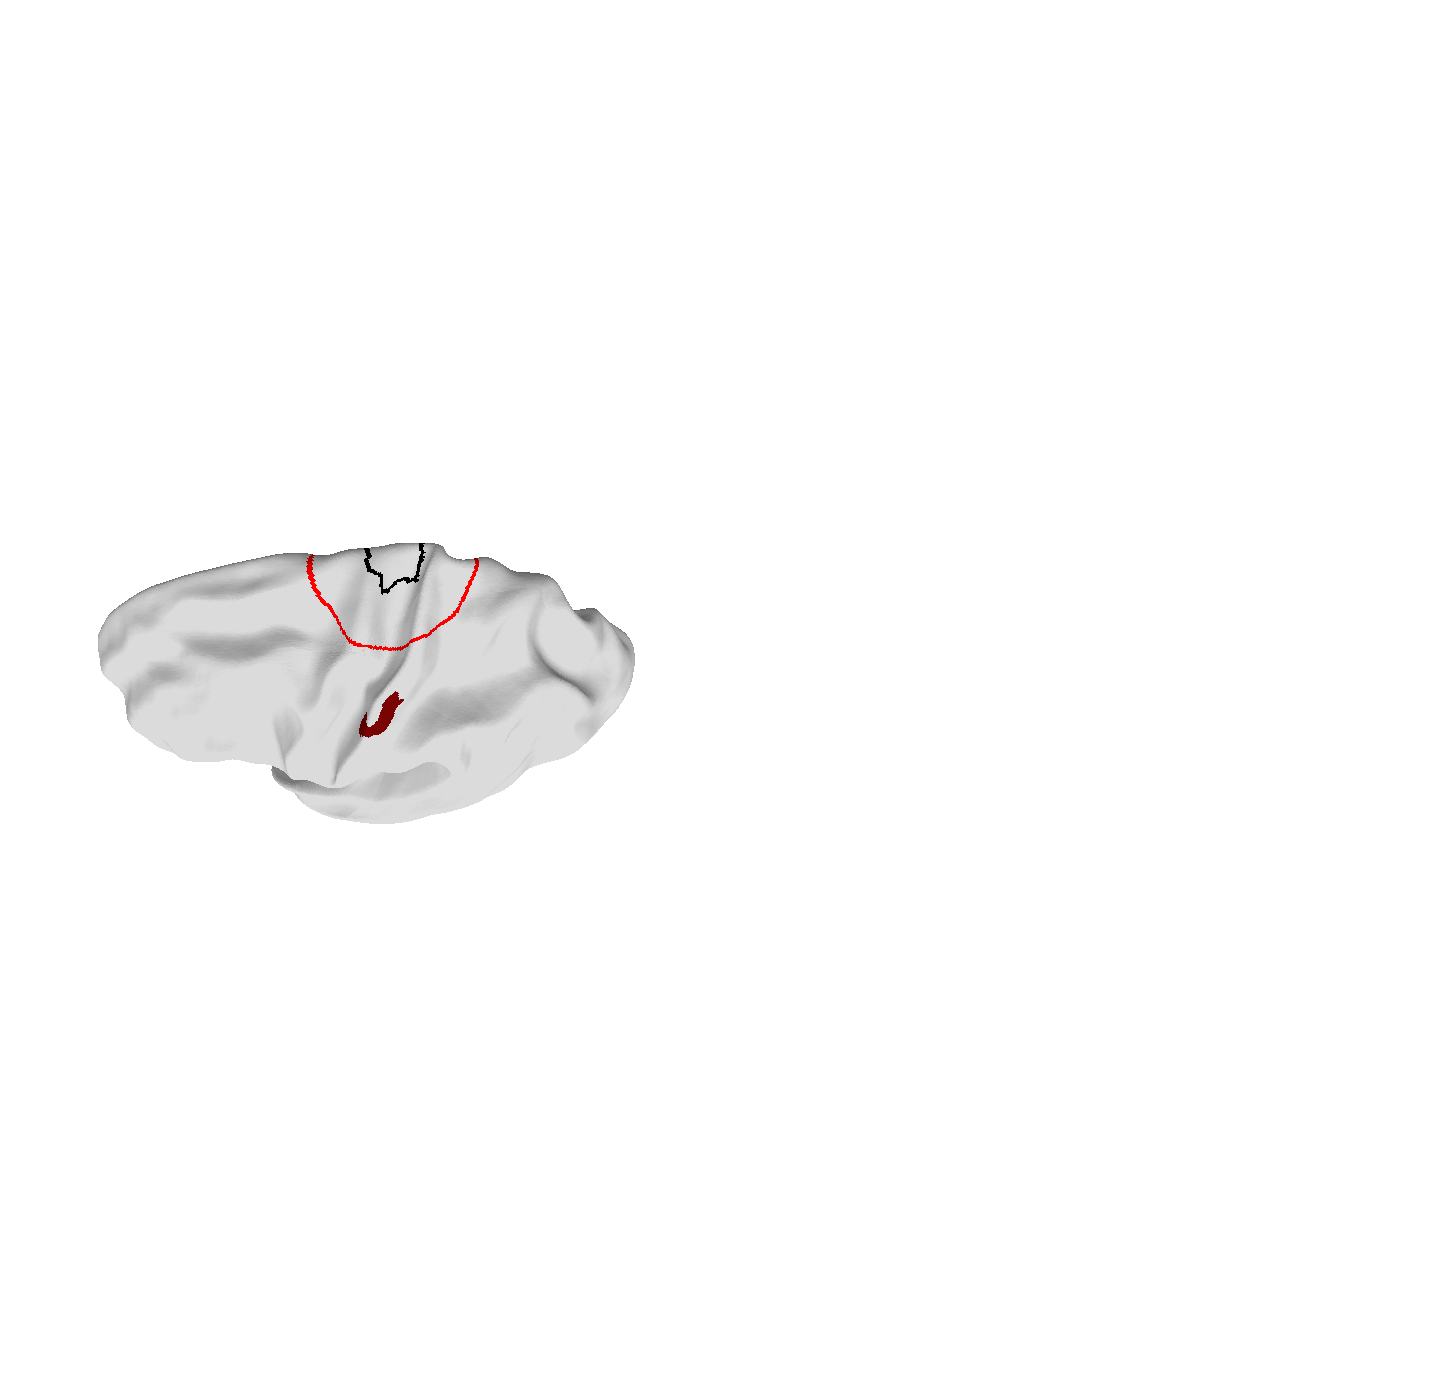

In [63]:
fig,axes = plt.subplots(6,3,figsize = (18,27))
k=-1
zoom_level=120
for mat in list_of_mats:
    for sub in mat.keys():
        k+=1
        x,z=mat[sub][0],mat[sub][1]
        offset = [mat[sub][2],mat[sub][3]]
        a,b,rot=get_image(sub,x=x,z=z,cohort=c)
        axes[k,0].imshow(a)
        axes[k,0].axis('off')
        axes[k,1].imshow(b)
        axes[k,1].axis('off')
        axes[k,2].imshow(rot[rot.shape[0]//2-zoom_level+offset[0]:rot.shape[0]//2+zoom_level+offset[0],
               rot.shape[1]//2-zoom_level+offset[1]:rot.shape[1]//2+zoom_level+offset[1],])
        axes[k,2].axis('off')
        

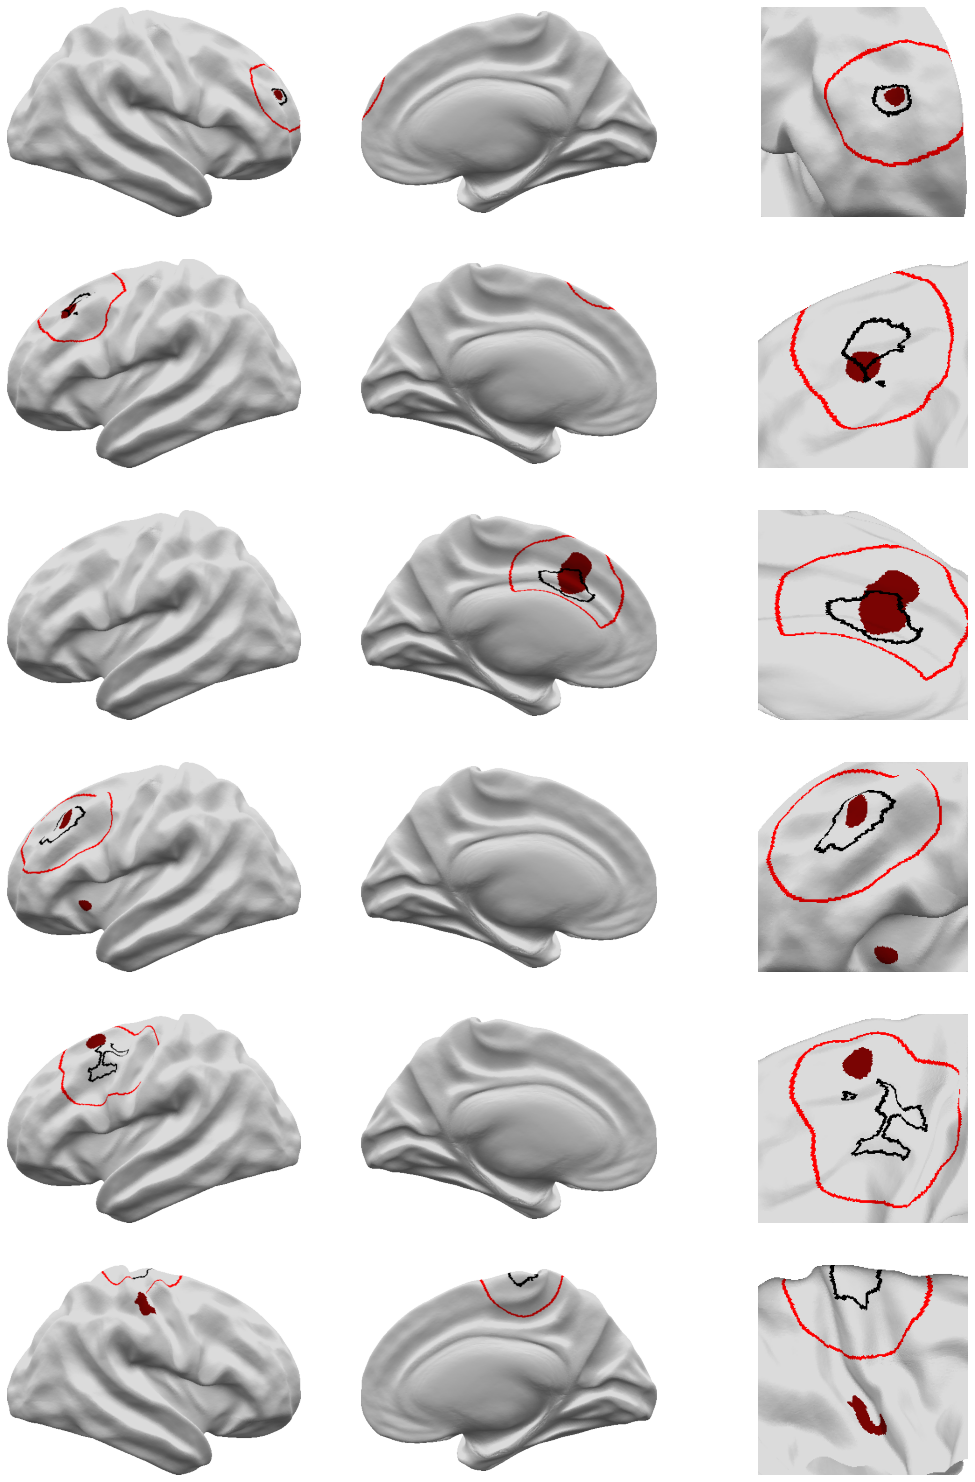

In [64]:
fig

In [65]:
fig.savefig('subject_prediction_plots.pdf')